In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

#Functions to calculate RSI and SMAs
def calculate_rsi(data, period=9):
    #Calculate the price differences (deltas)
    deltas = data['Close'].diff()

    #Calculate the gains and losses- Inputs value as '0' where condition is False
    gains = deltas.where(deltas > 0, 0)
    losses = -deltas.where(deltas < 0, 0)

    #Calculate the average gains and losses over the RSI period
    avg_gain = gains.rolling(window=period, min_periods=1).mean()
    avg_loss = losses.rolling(window=period, min_periods=1).mean()

    #Calculate the Relative Strength (RS) and the Relative Strength Index (RSI)
    rs = avg_gain / avg_loss
    rsi = 100.0 - (100.0 / (1.0 + rs))

    return rsi

def calculate_sma(data, window=200):
    return data['Close'].rolling(window=window, min_periods=1).mean()

def calculate_sma_SL(data, window=20):
    return data['Close'].rolling(window=window, min_periods=1).mean()

#The backtesting function
def backtest_trades(data, initial_capital):
    # Trading variables to keep track of successful and failed trades
    successful_buy_trades = 0
    failed_buy_trades = 0
    total_buy_points_gained_or_lost = 0

    successful_sell_trades = 0
    failed_sell_trades = 0
    total_sell_points_gained_or_lost = 0

    #Triggering buy/sell trades based on conditions
    in_buy_trade = False
    in_sell_trade = False
    buy_trade_info = []
    sell_trade_info = []

    for index, row in data.iloc[:-1].iterrows():
        #Buy Trade
        entry_time = row["Open Time"]

        if row["Buy_Signal"] and not data["Buy_Signal"].shift(1).loc[index] and in_buy_trade == False:
            in_buy_trade = True
            buy_stop_loss = row["buy_Stop_Loss"]
            entry_price = row["Close"]
            buy_target = row["Buy_Target"]
            print("Buy Signal triggered at index:", index)
            print("Buy Entry Price:", entry_price)
            print("Buy Stop Loss set to:", buy_stop_loss)
            print("Buy Target set to:", buy_target)

            #Determine whether the buy trade hit Stop Loss or Target
            buy_trade_result = None

            #Append buy trade information to the list
            buy_trade_info.append(
                {
                    "Index": index,
                    "Entry time": entry_time,
                    "Entry Price": entry_price,
                    "Stop Loss": buy_stop_loss,
                    "Target": buy_target,
                    "Trade Result": buy_trade_result,
                    "Datetime of close": entry_time if buy_trade_result else '',
                }
            )

        #Sell Trade
        if row["Sell_Signal"] and not data["Sell_Signal"].shift(1).loc[index] and in_sell_trade == False:
            in_sell_trade = True
            sell_stop_loss = row["sell_Stop_Loss"]
            entry_price = row["Close"]
            sell_target = row["Sell_Target"]
            print("Sell Signal triggered at index:", index)
            print("Sell Entry Price:", entry_price)
            print("Sell Stop Loss set to:", sell_stop_loss)
            print("Sell Target set to:", sell_target)

            #Determine whether the sell trade hit Stop Loss or Target
            sell_trade_result = None


            #Append sell trade information to the list
            sell_trade_info.append(
                {
                    "Index": index,
                    "Entry time": entry_time,
                    "Entry Price": entry_price,
                    "Stop Loss": sell_stop_loss,
                    "Target": sell_target,
                    "Trade Result": sell_trade_result,
                    "Datetime of close": entry_time if sell_trade_result else '',
                }
            )

        #Check for ongoing trades and update if stop loss or target is hit by the end of the dataset
        if in_buy_trade and not np.isnan(buy_target):
            last_data_index = index
            if data.loc[last_data_index, "Low"] <= buy_stop_loss:
                buy_trade_result = "Stop Loss Hit"
                failed_buy_trades += 1
                total_buy_points_gained_or_lost += (buy_stop_loss - entry_price)
                in_buy_trade = False
                buy_trade_info[-1]["Trade Result"] = buy_trade_result
                buy_trade_info[-1]["Datetime of close"] = entry_time
                   
            elif data.loc[last_data_index, "High"] >= buy_target:
                buy_trade_result = "Target Hit"
                successful_buy_trades += 1
                total_buy_points_gained_or_lost += (buy_target - entry_price)
                in_buy_trade = False
                buy_trade_info[-1]["Trade Result"] = buy_trade_result
                buy_trade_info[-1]["Datetime of close"] = entry_time

        if in_sell_trade and not np.isnan(sell_target):
            last_data_index = index
            if data.loc[last_data_index, "High"] >= sell_stop_loss:
                sell_trade_result = "Stop Loss Hit"
                failed_sell_trades += 1
                total_sell_points_gained_or_lost += (entry_price - sell_stop_loss)
                in_sell_trade = False
                sell_trade_info[-1]["Trade Result"] = sell_trade_result
                sell_trade_info[-1]["Datetime of close"] = entry_time

            elif data.loc[last_data_index, "Low"] <= sell_target:
                sell_trade_result = "Target Hit"
                successful_sell_trades += 1
                total_sell_points_gained_or_lost += (entry_price - sell_target)
                in_sell_trade = False
                sell_trade_info[-1]["Trade Result"] = sell_trade_result
                sell_trade_info[-1]["Datetime of close"] = entry_time

    #Converting the trade_info lists to DataFrames
    buy_trade_info_df = pd.DataFrame(buy_trade_info)
    sell_trade_info_df = pd.DataFrame(sell_trade_info)

    #Combining buy and sell trade info into a single DataFrame
    trade_info_df = pd.concat([buy_trade_info_df, sell_trade_info_df], ignore_index=True)

    #Calculating overall results
    total_trades = successful_buy_trades + failed_buy_trades + successful_sell_trades + failed_sell_trades
    total_points_gained_or_lost = total_buy_points_gained_or_lost + total_sell_points_gained_or_lost
    win_rate = (successful_buy_trades + successful_sell_trades) / total_trades * 100

    print("Backtesting Results:")
    print("Total Trades:", total_trades)
    print("Win Rate: {:.2f}%".format(win_rate))
    print("Total Points Gained/Lost for All Trades:", total_points_gained_or_lost)

    return trade_info_df

if __name__ == "__main__":
    #Loading the dataset
    dataset = pd.read_csv("BTCUSDT_stock_data_test_60mins_5year.csv")

    #Calculating RSI, SMAs, Signals, Stop Loss, and Targets
    dataset["RSI"] = calculate_rsi(dataset)
    dataset["200_SMA"] = calculate_sma(dataset)
    dataset["20SMA-SL"] = calculate_sma_SL(dataset)
    dataset["Difference_Val"] = np.where((dataset["Close"] - dataset["Close"].shift(1)) > 0,1 ,0)

    #Drop the first 200 rows as 200 rows do not have value for 200SMA
    dataset = dataset.dropna()
    
    #Combine input features
    features = ['RSI', 'Open', 'Low', 'High', 'Close', '200_SMA']
    X = dataset[features].values

    #Normalize the input features to the range [0, 1]
    scaler = MinMaxScaler()
    X = scaler.fit_transform(X)

    #Prepare the target variable (UP: 1, DOWN: 0)
    y = dataset["Difference_Val"]

    #Split the dataset into training and testing parts
    train_size = int(0.8 * len(X))
    X_train, X_test, y_train, y_test = X[:train_size], X[train_size:], y[:train_size], y[train_size:]

    #Reshape X_train to have 3D shape (batch_size, timesteps, input_dim)
    timesteps = 1  #We want each row to be treated as one timestep
    num_features = X_train.shape[1]
    X_train = X_train.reshape(X_train.shape[0], timesteps, num_features)

    #Define the LSTM model
    model = Sequential()
    model.add(LSTM(50, input_shape=(timesteps, num_features)))
    model.add(Dense(1, activation='sigmoid'))

    #Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    #Train the model
    model.fit(X_train, y_train, epochs=100, batch_size=32)

    #Predict close prices for the test part of the dataset
    predicted_close_prices = model.predict(X_test.reshape(X_test.shape[0], 1, X_test.shape[1]))
    
    predicted_directions = np.where(predicted_close_prices > np.roll(predicted_close_prices, -1).reshape(-1, 1), 1, 0).flatten()
    
    dataset['Predicted_Direction'] = np.nan
    dataset.loc[train_size + 1:, 'Predicted_Direction'] = predicted_directions
        
    #Flag for uptrend and downtrend
    dataset["Uptrend"] = dataset["Close"] > dataset["200_SMA"]
    dataset["Downtrend"] = dataset["Close"] < dataset["200_SMA"]

    #Calculating Buy_Signal and Sell_Signal
    dataset["Sell_Signal"] = np.where((dataset["Uptrend"] == True) & (dataset["RSI"] > 20) & (dataset["RSI"].shift(1)<20) & (dataset['Predicted_Direction'] == True), True, False)
    dataset["Buy_Signal"] = np.where((dataset["Downtrend"] == True) & (dataset["RSI"] < 80) & (dataset["RSI"].shift(1) > 80) & (dataset['Predicted_Direction'] == False), True, False)

    #Calculating the buy stop loss levels
    std_dev = dataset["Close"].rolling(window=20).std()
    dataset["buy_Stop_Loss"] = dataset["20SMA-SL"] - (1.5 * std_dev)

    #Calculating Buy Target
    dataset["Buy_Target"] = dataset["Close"] + 1*(dataset["Close"] - dataset["buy_Stop_Loss"])

    #Calculating the sell stop loss levels
    dataset["sell_Stop_Loss"] = dataset["20SMA-SL"] + (1.5 * std_dev)

    #Calculating Sell Target
    dataset["Sell_Target"] = dataset["Close"] - 1*(dataset["sell_Stop_Loss"] - dataset["Close"])
    
    #Setting initial capital to starting price of BTCUSDT in the test dataset
    initial_capital = dataset.loc[train_size, "Close"]

    #Calling backtesting function
    trade_info_df = backtest_trades(dataset, initial_capital)

    #Display the dataset with the added signals, stop loss, and target values
    print(dataset)

In [2]:
#Specifying the path and filename for the CSV file
csv_filename = 'trade_result.csv'

#Save the last 150 rows to a CSV file
trade_info_df.to_csv(csv_filename, index=False)

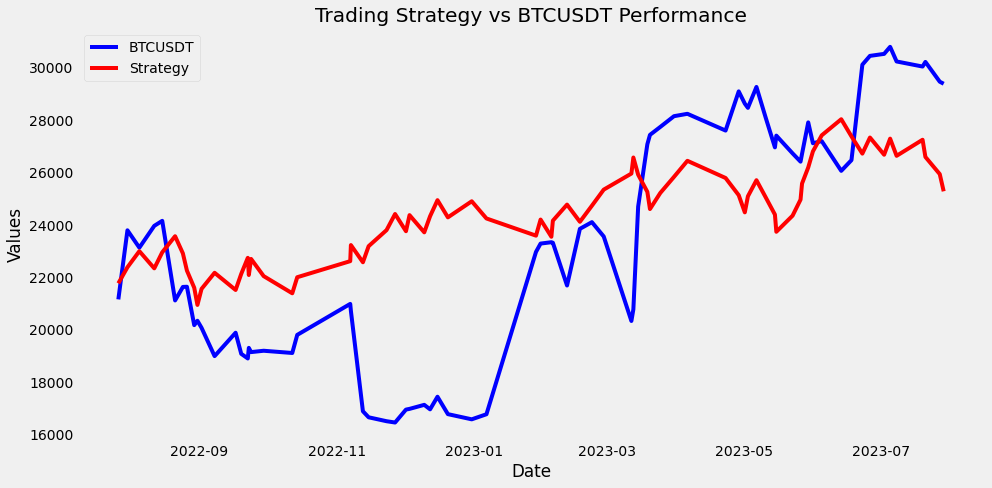

In [3]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')


#Loading the trade_info_df DataFrame
trade_info_df = pd.read_csv("trade_result.csv")  

#Converting Entry time column to datetime format using the specific format
trade_info_df["Entry time"] = pd.to_datetime(trade_info_df["Entry time"])

#Sorting the DataFrame based on Entry time
trade_info_df = trade_info_df.sort_values(by="Entry time")

#Calculating the profit for each trade
trade_info_df["Profit"] = np.where(trade_info_df["Trade Result"] == "Stop Loss Hit", -0.031, 0.029)

#Calculating cumulative profit changes
trade_info_df["Cumulative Profit"] = trade_info_df["Profit"].cumsum()

#Starting capital
starting_capital = trade_info_df["Entry Price"].iloc[0]  # Replace with your starting capital

#Calculate the equity (capital + cumulative profit)
trade_info_df["Equity"] = starting_capital
for idx, row in trade_info_df.iterrows():
    trade_info_df.at[idx, "Equity"] += row["Cumulative Profit"] * trade_info_df.at[idx, "Equity"]

#Plotting the running total of cumulative profits and the equity on a line chart
plt.figure(figsize=(14, 7))

plt.plot(trade_info_df["Entry time"], trade_info_df["Entry Price"], color='b', label="BTCUSDT")
plt.plot(trade_info_df["Entry time"], trade_info_df["Equity"], color='r', label="Strategy")

plt.xlabel("Date")
plt.ylabel("Values")
plt.title("Trading Strategy vs BTCUSDT Performance")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()


In [4]:
#Calculate Percent Return for Trading Strategy
final_equity = trade_info_df["Equity"].iloc[-1]  #The final equity value in the DataFrame
percent_return_strategy = ((final_equity - initial_capital) / initial_capital) * 100

#For BTCUSDT Buy and Hold
initial_BTCUSDT_price = trade_info_df["Entry Price"].iloc[0]  #Assuming the first entry price as initial BTCUSDT price
final_BTCUSDT_price = trade_info_df["Entry Price"].iloc[-1]  #Assuming the last entry price as final BTCUSDT price
percent_return_BTCUSDT = ((final_BTCUSDT_price - initial_BTCUSDT_price) / initial_BTCUSDT_price) * 100

print(f"Percent Return for Trading Strategy: {percent_return_strategy:.2f}%")
print(f"Percent Return for BTCUSDT Buy and Hold: {percent_return_BTCUSDT:.2f}%")


Percent Return for Trading Strategy: 14.93%
Percent Return for BTCUSDT Buy and Hold: 38.90%


In [5]:
#Function to calculate Drawdown
def calculate_drawdown(series):
    #Calculate the running maximum
    running_max = series.expanding(min_periods=1).max()
    #Calculate the drawdown series
    drawdown = series / running_max - 1
    return drawdown

#Function to calculate Max Drawdown
def calculate_max_drawdown(series):
    drawdown = calculate_drawdown(series)
    #Calculate the maximum drawdown
    max_drawdown = drawdown.min()
    return max_drawdown


Max Drawdown of Strategy: -11.13%
Max Drawdown of BTCUSDT: -31.87%


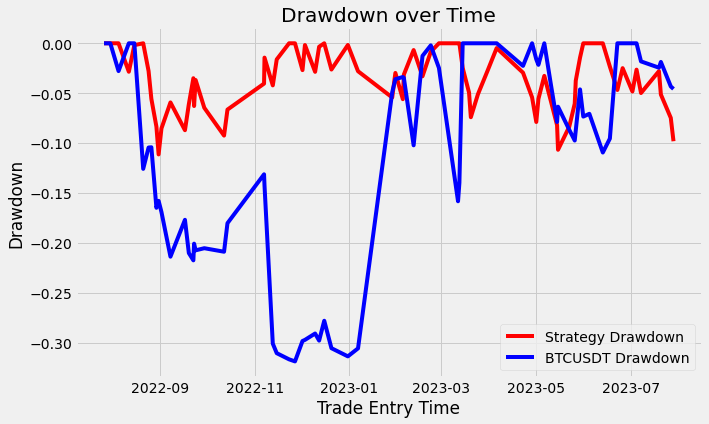

In [6]:
#Calculate drawdown for strategy and BTCUSDT
trade_info_df["Strategy_Drawdown"] = calculate_drawdown(trade_info_df["Equity"])
trade_info_df["BTCUSDT_Drawdown"] = calculate_drawdown(trade_info_df["Entry Price"])

#Calculate Max Drawdown for strategy and BTCUSDT
max_drawdown_strategy = calculate_max_drawdown(trade_info_df["Equity"])
max_drawdown_btc = calculate_max_drawdown(trade_info_df["Entry Price"])

#Print Max Drawdown values
print(f"Max Drawdown of Strategy: {max_drawdown_strategy * 100:.2f}%")
print(f"Max Drawdown of BTCUSDT: {max_drawdown_btc * 100:.2f}%")

#Plot the drawdown
plt.figure(figsize=(10, 6))
plt.plot(trade_info_df["Entry time"], trade_info_df["Strategy_Drawdown"], label="Strategy Drawdown", color='r')
plt.plot(trade_info_df["Entry time"], trade_info_df["BTCUSDT_Drawdown"], label="BTCUSDT Drawdown", color='b')

plt.xlabel("Trade Entry Time")
plt.ylabel("Drawdown")
plt.title("Drawdown over Time")
plt.grid(True)
plt.legend()
plt.show()
